Importing Libraries and Dependencies

In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Importing necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scripts.balanced_generator import BalanceCovidDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse
import os

Initialising model arguments and constants

In [3]:
# Construct the parser and initialise arguments
parser = argparse.ArgumentParser(description='COVID-CNN')

parser.add_argument('--input_size', default=480, type=int, help='Dimensions of the input image')
parser.add_argument('--n_channels', default=3, type=int, help='Number of channels in the image')
parser.add_argument('--train_file', default='train_split.txt', type=str, help='Name of train metadata file')
parser.add_argument('--test_file', default='test_split.txt', type=str, help='Name of test metadata file')
parser.add_argument('--data_dir', default='data', type=str, help='Path to data folder containing datasets')
parser.add_argument('--train_data_dir', default='train', type=str, help='Path to folder containing training dataset')
parser.add_argument('--test_data_dir', default='test', type=str, help='Path to folder containing testing dataset')
parser.add_argument('--num_classes', default=3, type=int, help='Number of classes in the dataset')
parser.add_argument('--num_channels', default=3, type=int, help='Number of channels per image')
parser.add_argument('--epochs', default=1, type=int, help='Number of epochs to train for')
parser.add_argument('--bs', default=8, type=int, help='Batch size')
parser.add_argument('--lr', default=0.0002, type=float, help='Learning rate')
parser.add_argument("-p", "--plot", type=str, default="plots/plot_ResNet50.png", help="Path to save loss/accuracy plot")
parser.add_argument("-mp", "--model_plot", type=str, default="plots/model_plot_ResNet50.png", help="Path to save model's plot")
parser.add_argument("--model_dir", type=str, default="saved_models/", help="Path to save model")
parser.add_argument("--model_name", type=str, default="ResNet50", help="Name of the model")

args, unknown = parser.parse_known_args()

# Declaring constants
EPOCHS = args.epochs
BS = args.bs
LR = args.lr

Data exploration

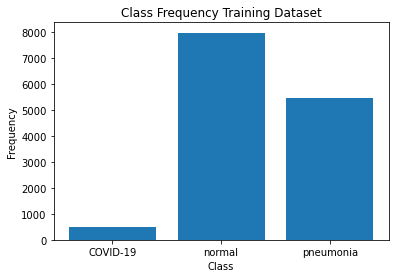

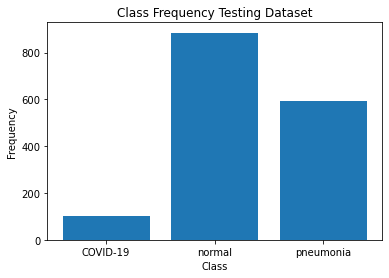

In [4]:
# Reading training dataset csv and extracting labels
df_train = pd.read_csv(args.train_file, sep=' ', header=0, index_col=None)
train_labels = df_train['class']

# Reading testing dataset csv and extracting labels
df_test = pd.read_csv(args.test_file, sep=' ', header=0, index_col=None)
test_labels = df_test['class']

# Extracting unique classes
classes = test_labels.unique()

# Plotting distribution of classes in training dataset
unique, counts = np.unique(train_labels, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency Training Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

# Plotting distribution of classes in testing dataset
unique, counts = np.unique(test_labels, return_counts=True)
plt.bar(unique, counts)

plt.title('Class Frequency Testing Dataset')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

Creating the model

In [4]:
# Loading ResNet50 model trained on imagenet without head
baseModel = ResNet50(
    weights="imagenet", include_top=False,
    input_tensor=Input(shape=(args.input_size, args.input_size,
                              args.n_channels))
)

# Constructing the head for classification (to be trained)
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

# Fixing the weights of base model
baseModel.trainable = False

#  Adding regularisation
model = Model(inputs=baseModel.input, outputs=headModel)

Instantiating data generators to load datasets

In [5]:
map = {
        'normal': 0,
        'pneumonia': 1,
        'COVID-19': 2
        }
test_generator = BalanceCovidDataset(
        data_dir=os.path.join(args.data_dir),
        data_files=df_test.to_csv(header=None, index=False, sep=" ").strip('\n').split("\n"),
        batch_size=1,
        input_shape=(args.input_size, args.input_size),
        num_channels=args.num_channels,
        mapping=map,
        is_training=False,
        is_validation=False,
        is_testing=True
)


def get_model(df_trn, df_val):
    map = {
            'normal': 0,
            'pneumonia': 1,
            'COVID-19': 2
            }
    trn_generator = BalanceCovidDataset(
        data_dir=os.path.join(args.data_dir),
        data_files=df_trn.to_csv(header=None, index=False, sep=" ").strip('\n').split("\n"),
        batch_size=BS,
        input_shape=(args.input_size, args.input_size),
        num_channels=args.num_channels,
        mapping=map
    )

    val_generator = BalanceCovidDataset(
        data_dir=os.path.join(args.data_dir),
        data_files=df_val.to_csv(header=None, index=False, sep=" ").strip('\n').split("\n"),
        batch_size=BS,
        input_shape=(args.input_size, args.input_size),
        num_channels=args.num_channels,
        mapping=map,
        is_training=False,
        is_validation=True
    )

    return model, trn_generator, val_generator

Training the model

[INFO] Training model
1125/1125 [==============================] - 247s 219ms/step - loss: 0.6890 - accuracy: 0.9223 - val_loss: 0.3578 - val_accuracy: 0.9472


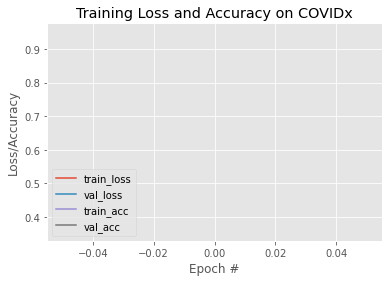

In [6]:
X_train, X_test, _, _ = train_test_split(df_train, df_train['class'], test_size=0.33, random_state=42)

# Getting model and generators fitted on ith fold data
model, train_generator, validation_generator = get_model(X_train, X_test)

# Compiling the model
opt = Adam(learning_rate=LR)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])

train_classes = pd.DataFrame(train_generator.classes)
n_train = len(train_classes[train_classes.isin(['normal', 'pneumonia'])])

val_classes = pd.DataFrame(validation_generator.classes)
n_val = len(val_classes[val_classes.isin(['normal', 'pneumonia'])])

#print('n_train: {}, n_val:{}'.format(n_train,n_val))

# Training model
print("[INFO] Training model")
H = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=EPOCHS)

# Plotting training loss and accuracy
N = len(H.history["loss"])
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVIDx")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args.plot)

Evaluating the model and generating predictions

In [7]:
# Predicting on testing data
print("[INFO] Predicting on testing data")

nb_samples = len(df_test[df_test['class'].isin(['normal','pneumonia'])])

# Loading best model
pred = model.predict(test_generator, steps=len(test_generator), verbose=1)
pred = np.argmax(pred, axis=1)

# Printing classification report
print(classification_report(df_test['class'], pred))

[INFO] Predicting on testing data
1579/1579 [==============================] - 44s 28ms/step


ValueError: Mix of label input types (string and number)

Printing confusion matrix

In [ ]:
# Generating confusion matrix and calculating: accuracy, sensitivity and specificity
cm = confusion_matrix(test_generator.classes, pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
TN = cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]
FP = cm[1, 0] + cm[2, 0]
specificity = TN / (TN + FP)

# Printing found values
print(cm)
print("Overall Accuracy: {:.4f}".format(acc))
print("COVID Sensitivity: {:.4f}".format(sensitivity))
print("COVID Specificity: {:.4f}".format(specificity))

Plotting the training performance

In [ ]:
# Plotting training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVIDx Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args.plot)